In [1]:
# モジュールのインポート
from matplotlib import pyplot
from matplotlib import patches
import random
import numpy as np
import array

from itertools import repeat
from collections.abc import Sequence
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
%matplotlib inline

In [2]:
# roomというclassを作る
class Room():
    def __init__(self,n,s,fre_move,w=0,l=0,x=0,y=0):
        self.n = n
        self.s = s
        self.fre_move = fre_move
        self.x = x
        self.y = y
        self.w = w
        self.l = l
        
    def distance(self,b):
        return (abs(self.x-b.x)+abs(self.y-b.y))*self.fre_move[b.n]
    def construction(self):
        S = self.w*self.l
        wall = (self.w+self.l)*2
        return S*1+wall*2
    def penalty(self):
        S = self.w*self.l
        return abs(S-self.s)

In [3]:
# 遺伝子を生成
def room_gene():
    # seq_rooms
    gene = random.sample(range(0,8),8)
    # width,length
    for i in range(16):
        gene.append(random.randint(1,10))
    # start_point
    for i in range(2):
        gene.append(random.randint(0,10))
    # y
    for i in range(8):
        gene.append(random.randint(0,1))
    return gene

In [4]:
# 評価関数
def Eval(individual):
    seq = individual[0:8]
    width = individual[8:16]
    length = individual[16:24]
    start_point = individual[24:26]
    up_or_down = individual[26:34]
    
    global Rooms
    for room in Rooms:
        room.w = width[room.n]
        room.l = length[room.n]
        room.y = up_or_down[room.n]
    seq_rooms = [i for _, i in sorted(zip(seq, Rooms))]
    zero = []
    one = []
    for seq_room in seq_rooms:
        
        if seq_room.y == 0:
            left_point = start_point[0]+sum(zero)
            seq_room.x = left_point+seq_room.w/2
            zero.append(seq_room.w)
        else:
            left_point = start_point[1]+sum(one)
            seq_room.x = left_point+seq_room.w/2
            one.append(seq_room.w)
    distance_cost = []
    construction_cost = []
    penalty_sum = []
    for room in Rooms:
        distance_cost.append(sum([room.distance(i) for i in Rooms]))
        construction_cost.append(room.construction())
        penalty_sum.append(room.penalty())
    dis_c = sum(distance_cost)
    con_c = sum(construction_cost)
    pen_c = sum(penalty_sum)
    a1,a2,a3 = 2,1,5
    return dis_c*a1+con_c*a2+pen_c*a3,


In [5]:
# 交叉
def CX(ind1, ind2, indpb=0.05):
    seq1,seq2 = ind1[0:8],ind2[0:8]
    wl1, wl2= ind1[8:26], ind2[8:26]
    up_or_down1, up_or_down2 = ind1[26:34], ind2[26:34]
    
    ## cxPartialyMatched
    size1 = min(len(seq1), len(seq2))
    p1, p2 = [0] * size1, [0] * size1

    # Initialize the position of each indices in the individuals
    for i in range(size1):
        p1[seq1[i]] = i
        p2[seq2[i]] = i
    # Choose crossover points
    cxpoint1 = random.randint(0, size1)
    cxpoint2 = random.randint(0, size1 - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else:  # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    # Apply crossover between cx points
    for i in range(cxpoint1, cxpoint2):
        # Keep track of the selected values
        temp1 = seq1[i]
        temp2 = seq2[i]
        # Swap the matched value
        seq1[i], seq1[p1[temp2]] = temp2, temp1
        seq2[i], seq2[p2[temp1]] = temp1, temp2
        # Position bookkeeping
        p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
        p2[temp1], p2[temp2] = p2[temp2], p2[temp1]

    ## cxTwoPoint1
    size2 = min(len(wl1), len(wl2))
    cxpoint3 = random.randint(1, size2)
    cxpoint4 = random.randint(1, size2 - 1)
    if cxpoint4 >= cxpoint3:
        cxpoint4 += 1
    else:  # Swap the two cx points
        cxpoint3, cxpoint4 = cxpoint4, cxpoint3

    wl1[cxpoint3:cxpoint4], wl2[cxpoint3:cxpoint4] \
        = wl2[cxpoint3:cxpoint4], wl1[cxpoint3:cxpoint4]

    ## cxTwoPoint2
    size3 = min(len(up_or_down1), len(up_or_down2))
    cxpoint5 = random.randint(1, size3)
    cxpoint6 = random.randint(1, size3 - 1)
    if cxpoint6 >= cxpoint5:
        cxpoint6 += 1
    else:  # Swap the two cx points
        cxpoint5, cxpoint6 = cxpoint6, cxpoint5

    up_or_down1[cxpoint5:cxpoint5], up_or_down2[cxpoint5:cxpoint6] \
        = up_or_down2[cxpoint5:cxpoint6], up_or_down1[cxpoint5:cxpoint6]
    
    ind1 = seq1+wl1+up_or_down1
    ind2 = seq2+wl2+up_or_down2
    return ind1, ind2

In [6]:
# 突然変異
def MUT(individual, low, up, indpb):
    seq = individual[0:8]
    wl = individual[8:26]
    up_or_down = individual[26:34]
    
    # mutShuffleIndexes
    size1 = len(seq)
    for i in range(size1):
        if random.random() < indpb:
            swap_indx = random.randint(0, size1 - 2)
            if swap_indx >= i:
                swap_indx += 1
            seq[i], seq[swap_indx] = \
                seq[swap_indx], seq[i]

    # mutUniformInt
    if random.random() < indpb:
        wl = []
        for i in range(8):
            wl.append(random.randint(1,10))
        for i in range(8):
            wl.append(random.randint(1,10))
        for i in range(2):# start_point
            wl.append(random.randint(0,10))

    # mutFlipBit
    for i in range(len(up_or_down)):
        if random.random() < indpb:
            up_or_down[i] = type(up_or_down[i])(not up_or_down[i])
    
    individual = seq+wl+up_or_down
    return individual,

In [7]:
# 定義
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# 初期条件を構築
toolbox.register("individual", tools.initIterate, creator.Individual, room_gene)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 評価関数、交差、突然変異、選択淘汰
toolbox.register("evaluate", Eval)
toolbox.register("mate", CX, indpb=0.5)
toolbox.register("mutate", MUT,low=1,up=10, indpb=0.5)
toolbox.register("select", tools.selTournament, tournsize=5)

In [8]:
def conf(best_ind):
    seq = best_ind[0:8]
    width = best_ind[8:16]
    length = best_ind[16:24]
    start_point = best_ind[24:26]
    up_or_down = best_ind[26:34]
    for room in Rooms:
            room.w = width[room.n]
            room.l = length[room.n]
            room.y = up_or_down[room.n]
    seq_rooms = [i for _, i in sorted(zip(seq, Rooms))]
    zero = []
    one = []
    for seq_room in seq_rooms:
        if seq_room.y == 0:
            left_point = start_point[0]+sum(zero)
            seq_room.x = left_point+seq_room.w/2
            zero.append(seq_room.w)
        else:
            left_point = start_point[1]+sum(one)
            seq_room.x = left_point+seq_room.w/2
            one.append(seq_room.w)
    fig, ax = pyplot.subplots()

    ax.set_xlim([0,21])
    ax.set_ylim([-11,11])
    ax.grid()
    ax.add_patch(patches.Rectangle( xy=(0,-10.5) ,facecolor="white",edgecolor="black", width=20, height=21))

    for room in Rooms:
        if room.y == 0:
            y = 1
        else:
            y = -1*room.l
        r = patches.Rectangle( xy=(room.x-room.w/2,y) ,facecolor="white",edgecolor="red", width=room.w, height=room.l) 
        ax.add_patch(r)
    ax.add_patch(patches.Rectangle( xy=(0,0) ,facecolor="white",edgecolor="black", width=20, height=1))

    pyplot.axis('off')
    pyplot.show()

In [80]:
def main():
    pop = toolbox.population(n=1000)
    CXPB, MUTPB ,NGEN = 1, 1, 50
    print("Start of evolution")

    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    fits = [ind.fitness.values[0] for ind in pop]
    log_min = [min(fits)]
    log_max = [max(fits)]
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    log_mean = [mean]
    log_std = [std]
    
    print("  Evaluated %i individuals" % len(pop))
    print("gen   nevals      avg      std      min     max" )
    
    for g in range(NGEN):
        
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        pop[:] = offspring

        fits = [ind.fitness.values[0] for ind in pop]
        
        # 母集団の最小、最大、平均、標準偏差を表示
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        log_min.append(min(fits))
        log_max.append(max(fits))
        log_mean.append(mean)
        log_std.append(std)
        gen = list(range(0, NGEN+1))

        print('%2d　　  %4d　  %5d　　%5d　　%5d　 %5d' % (g,len(invalid_ind),mean,std,min(fits),max(fits)))
    print("-- End of (successful) evolution --")
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    return best_ind, gen, log_min, log_max, log_mean, log_std

Start of evolution
  Evaluated 1000 individuals
gen   nevals      avg      std      min     max
 0　　  1000　   1980　　  331　　 1168　  3314
 1　　  1000　   1598　　  187　　 1168　  2260
 2　　  1000　   1385　　  120　　 1168　  1800
 3　　  1000　   1244　　   88　　 1168　  1402
 4　　  1000　   1169　　   15　　 1168　  1336
 5　　  1000　   1168　　    0　　 1168　  1168
 6　　  1000　   1168　　    0　　 1168　  1168
 7　　  1000　   1168　　    0　　 1168　  1168
 8　　  1000　   1168　　    0　　 1168　  1168
 9　　  1000　   1168　　    0　　 1168　  1168
10　　  1000　   1168　　    0　　 1168　  1168
11　　  1000　   1168　　    0　　 1168　  1168
12　　  1000　   1168　　    0　　 1168　  1168
13　　  1000　   1168　　    0　　 1168　  1168
14　　  1000　   1168　　    0　　 1168　  1168
15　　  1000　   1168　　    0　　 1168　  1168
16　　  1000　   1168　　    0　　 1168　  1168
17　　  1000　   1168　　    0　　 1168　  1168
18　　  1000　   1168　　    0　　 1168　  1168
19　　  1000　   1168　　    0　　 1168　  1168
20　　  1000　   1168　　    0　　 1168　  1168
21　　  1000　   1168　　    0　　 1168　  1168
22　　  1000　   1168　　    

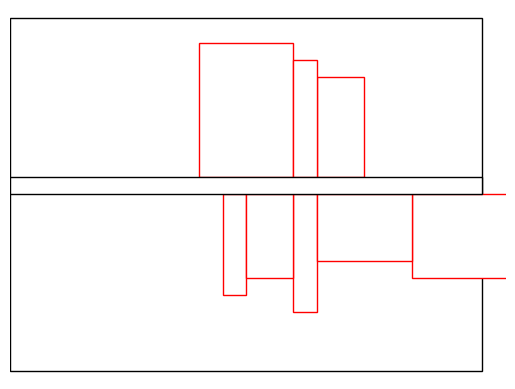

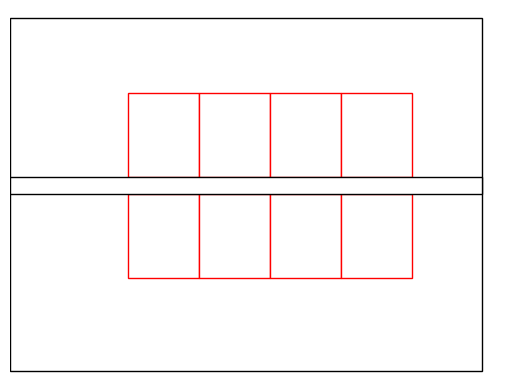

In [81]:
# 設定（部屋番号,部屋の面積,部屋と部屋の間の移動コスト）
Room_1 = Room(0,15,[0,1,1,1,1,1,1,1])
Room_2 = Room(1,15,[1,0,1,1,1,1,1,1])
Room_3 = Room(2,15,[1,1,0,1,1,1,1,1])
Room_4 = Room(3,15,[1,1,1,0,1,1,1,1])
Room_5 = Room(4,15,[1,1,1,1,0,1,1,1])
Room_6 = Room(5,15,[1,1,1,1,1,0,1,1])
Room_7 = Room(6,15,[1,1,1,1,1,1,0,1])
Room_8 = Room(7,15,[1,1,1,1,1,1,1,0])
Rooms = [Room_1,Room_2,Room_3,Room_4,Room_5,Room_6,Room_7,Room_8]

# 実行
if __name__ == "__main__":
    best_ind, gen, log_min, log_max, log_mean, log_std = main()
Best = [0, 1, 2, 3, 4, 5, 6, 7, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1]
conf(best_ind)
conf(Best)